In [4]:
import os
os.environ['http_proxy'] = 'http://127.0.0.1:7890'
os.environ['https_proxy'] = 'http://127.0.0.1:7890'

In [3]:
import torch
from datasets import load_dataset
from transformer_lens import HookedTransformer
from sae_lens import SAE

In [37]:
import plotly.express as px

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### models

In [5]:
model = HookedTransformer.from_pretrained("gpt2-small", device=device)

/home/whaow/anaconda3/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1602: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Loaded pretrained model gpt2-small into HookedTransformer


In [6]:
sae, cfg_dict, sparsity = SAE.from_pretrained(
    release="gpt2-small-res-jb",  # see other options in sae_lens/pretrained_saes.yaml
    sae_id="blocks.8.hook_resid_pre",  # won't always be a hook point
    device=device,
)

blocks.8.hook_resid_pre/cfg.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

sae_weights.safetensors:   0%|          | 0.00/151M [00:00<?, ?B/s]

sparsity.safetensors:   0%|          | 0.00/98.4k [00:00<?, ?B/s]

/home/whaow/anaconda3/lib/python3.10/site-packages/sae_lens/sae.py:145: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


In [8]:
cfg_dict

{'model_name': 'gpt2-small',
 'hook_point': 'blocks.8.hook_resid_pre',
 'hook_point_layer': 8,
 'hook_point_head_index': None,
 'dataset_path': 'Skylion007/openwebtext',
 'is_dataset_tokenized': False,
 'context_size': 128,
 'use_cached_activations': False,
 'cached_activations_path': 'activations/Skylion007_openwebtext/gpt2-small/blocks.8.hook_resid_pre',
 'd_in': 768,
 'n_batches_in_buffer': 128,
 'total_training_tokens': 300000000,
 'store_batch_size': 32,
 'device': 'cuda',
 'seed': 42,
 'dtype': 'torch.float32',
 'b_dec_init_method': 'geometric_median',
 'expansion_factor': 32,
 'from_pretrained_path': None,
 'l1_coefficient': 8e-05,
 'lr': 0.0004,
 'lr_scheduler_name': None,
 'lr_warm_up_steps': 5000,
 'train_batch_size': 4096,
 'use_ghost_grads': False,
 'feature_sampling_window': 1000,
 'feature_sampling_method': None,
 'resample_batches': 1028,
 'feature_reinit_scale': 0.2,
 'dead_feature_window': 5000,
 'dead_feature_estimation_method': 'no_fire',
 'dead_feature_threshold': 1

In [7]:
sparsity

tensor([-2.8268, -3.0495, -2.9602,  ..., -2.5930, -3.1867, -2.5810],
       device='cuda:0')

In [9]:
sae

SAE(
  (activation_fn): ReLU()
  (hook_sae_input): HookPoint()
  (hook_sae_acts_pre): HookPoint()
  (hook_sae_acts_post): HookPoint()
  (hook_sae_output): HookPoint()
  (hook_sae_recons): HookPoint()
  (hook_sae_error): HookPoint()
)

### dataset

In [35]:
# model

In [11]:
model.tokenizer

GPT2TokenizerFast(name_or_path='gpt2', vocab_size=50257, model_max_length=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	50256: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}

In [13]:
sae.cfg.context_size, sae.cfg.prepend_bos

(128, True)

In [10]:
from transformer_lens.utils import tokenize_and_concatenate

dataset = load_dataset(
    path="NeelNanda/pile-10k",
    split="train",
    streaming=False,
)

token_dataset = tokenize_and_concatenate(
    dataset=dataset,  # type: ignore
    tokenizer=model.tokenizer,  # type: ignore
    streaming=True,
    max_length=sae.cfg.context_size,
    add_bos_token=sae.cfg.prepend_bos,
)

Generating train split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (229134 > 1024). Running this sequence through the model will result in indexing errors


### Basic Analysis

In [30]:
model.tokenizer

GPT2TokenizerFast(name_or_path='gpt2', vocab_size=50257, model_max_length=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	50256: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}

In [31]:
sae

SAE(
  (activation_fn): ReLU()
  (hook_sae_input): HookPoint()
  (hook_sae_acts_pre): HookPoint()
  (hook_sae_acts_post): HookPoint()
  (hook_sae_output): HookPoint()
  (hook_sae_recons): HookPoint()
  (hook_sae_error): HookPoint()
)

In [14]:
token_dataset[:32]["tokens"]

tensor([[50256,  1026,   318,  ...,   644,  1611,   286],
        [50256,   983,   314,  ...,   983,    11,   345],
        [50256,   761,   284,  ...,   765,   284,  2251],
        ...,
        [50256,     1,  3509,  ...,  1279,  3672,    29],
        [50256,  5760,    16,  ...,  1279, 11213,    29],
        [50256, 36376,  2561,  ...,  1279, 19608,   265]])

In [15]:
token_dataset[:32]["tokens"].shape

torch.Size([32, 128])

In [33]:
sae.cfg

SAEConfig(architecture='standard', d_in=768, d_sae=24576, activation_fn_str='relu', apply_b_dec_to_input=True, finetuning_scaling_factor=False, context_size=128, model_name='gpt2-small', hook_name='blocks.8.hook_resid_pre', hook_layer=8, hook_head_index=None, prepend_bos=True, dataset_path='Skylion007/openwebtext', dataset_trust_remote_code=True, normalize_activations='none', dtype='torch.float32', device='cuda', sae_lens_training_version=None, activation_fn_kwargs={}, neuronpedia_id='gpt2-small/8-res-jb', model_from_pretrained_kwargs={'center_writing_weights': True}, seqpos_slice=(None,))

In [41]:
sae.cfg.d_sae / sae.cfg.d_in

32.0

In [36]:
sae.cfg.hook_name

'blocks.8.hook_resid_pre'

cache[sae.cfg.hook_name].shape torch.Size([32, 128, 768])
feature_acts.shape torch.Size([32, 128, 24576])
average l0 68.78986358642578


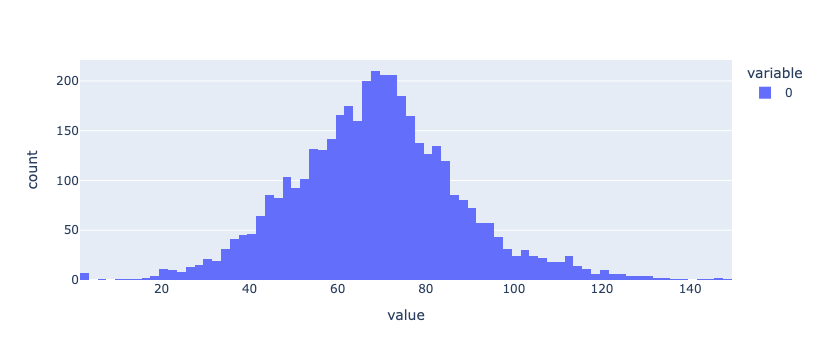

In [43]:
sae.eval()  # prevents error if we're expecting a dead neuron mask for who grads

with torch.no_grad():
    # activation store can give us tokens.
    batch_tokens = token_dataset[:32]["tokens"]
    _, cache = model.run_with_cache(batch_tokens, prepend_bos=True)

    # Use the SAE
    feature_acts = sae.encode(cache[sae.cfg.hook_name])
    sae_out = sae.decode(feature_acts)

    # save some room
    # del cache

    # ignore the bos token, get the number of features that activated in each token, averaged accross batch and position
    print('cache[sae.cfg.hook_name].shape', cache[sae.cfg.hook_name].shape)
    print('feature_acts.shape', feature_acts.shape)
    l0 = (feature_acts[:, 1:] > 0).float().sum(-1).detach()
    print("average l0", l0.mean().item())
    px.histogram(l0.flatten().cpu().numpy()).show()